# Mathematical Intuition Behind the Titan Habitability Index (THI)

This notebook provides a mathematical and geometric explanation of the core
algorithms and methodological choices used in the **Titan Habitability Index (THI)**.

The focus is on *intuition*, not implementation.

We explain:
- Why normalization is required
- How PCA reveals latent habitability dimensions
- Why clustering is meaningful after PCA
- How the THI formulation avoids mathematical pitfalls
- How sensitivity analysis validates the index

This notebook complements the main white paper.


In [ ]:
# Google Colab setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

plt.style.use("default")


## 1. Why Normalization Is Necessary

Habitability-related parameters originate from different physical domains:

- Chemical potential (dimensionless)
- Thermal stability (relative score)
- Geological indicators (binary or sparse)

These parameters differ in scale and distribution.
Distance-based methods (PCA, clustering) are sensitive to scale.

Robust scaling is used because:
- Planetary data contains physically meaningful extremes
- Median and IQR are resistant to outliers
- Density-based clustering (DBSCAN) depends on stable distance metrics


In [ ]:
np.random.seed(0)

# Simulated habitability-related features
raw_data = pd.DataFrame({
    "chemical_potential": np.random.uniform(0.2, 1.0, 200),
    "thermal_stability": np.random.uniform(0.4, 1.0, 200),
    "cryovolcanism": np.random.choice([0, 1], size=200, p=[0.85, 0.15])
})

scaler = RobustScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(raw_data),
    columns=raw_data.columns
)

raw_data.describe(), scaled_data.describe()


(       chemical_potential  thermal_stability  cryovolcanism
 count          200.000000         200.000000     200.000000
 mean             0.600350           0.694717       0.205000
 std              0.227701           0.176761       0.404715
 min              0.203756           0.406856       0.000000
 25%              0.401726           0.544376       0.000000
 50%              0.632206           0.677029       0.000000
 75%              0.772379           0.854307       0.000000
 max              0.999078           0.994203       1.000000,
        chemical_potential  thermal_stability  cryovolcanism
 count        2.000000e+02       2.000000e+02     200.000000
 mean        -8.594593e-02       5.706893e-02       0.205000
 std          6.143231e-01       5.703225e-01       0.404715
 min         -1.155931e+00      -8.717190e-01       0.000000
 25%         -6.218229e-01      -4.280092e-01       0.000000
 50%         -1.491862e-16       1.791102e-16       0.000000
 75%          3.781771e

## 2. Principal Component Analysis (PCA)

PCA is used **not** for compression or speed, but for *structure discovery*.

Key ideas:
- PCA rotates the feature space
- New axes represent combinations of correlated parameters
- Variance indicates information content

In the THI framework, PCA reveals **latent habitability dimensions**
formed by interacting chemical and environmental factors.


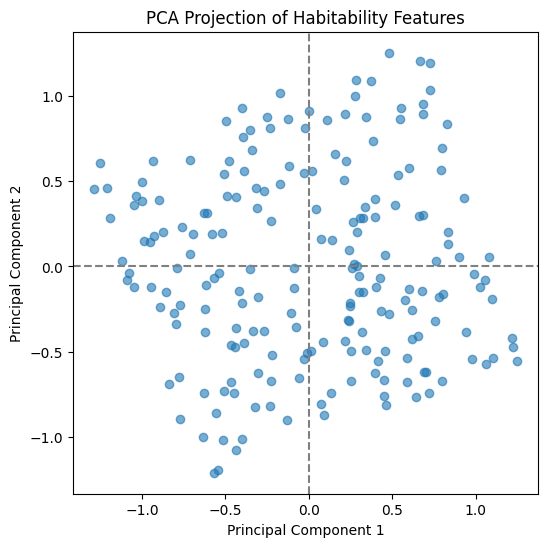

array([0.44515537, 0.37075638])

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Habitability Features")
plt.show()

pca.explained_variance_ratio_


## 3. Why PCA Is Zero-Centered (Critical Insight)

PCA produces components with:
- Mean = 0
- Positive and negative deviations

This means:
- Zero corresponds to an *average* Titan condition
- Sign indicates direction, not favorability

Therefore, habitability should not be computed using signed averages.
Instead, it should be measured as **magnitude in latent space**.


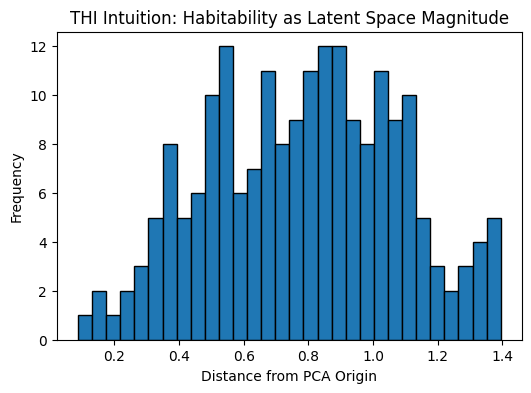

In [ ]:
# Euclidean magnitude in PCA space
thi_magnitude = np.sqrt((X_pca ** 2).sum(axis=1))

plt.figure(figsize=(6,4))
plt.hist(thi_magnitude, bins=30, edgecolor="black")
plt.xlabel("Distance from PCA Origin")
plt.ylabel("Frequency")
plt.title("THI Intuition: Habitability as Latent Space Magnitude")
plt.show()


## 4. Clustering in PCA Space

After PCA:
- Axes are orthogonal
- Distances are meaningful
- Redundancy is removed

Clustering groups points into **habitability neighborhoods**:
- Regions with similar chemical and thermal conditions
- Irregular and sparse regimes are expected

DBSCAN is used because:
- Habitability regions are not spherical
- Outliers (hostile zones) are meaningful
- Number of regimes is unknown


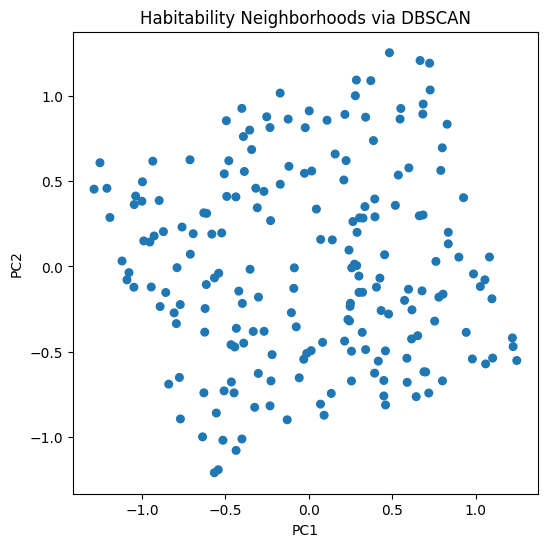

(array([0]), array([200]))

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X_pca)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap="tab10", s=30)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Habitability Neighborhoods via DBSCAN")
plt.show()

np.unique(labels, return_counts=True)


## 5. Mathematical Definition of THI

Let:
- $PC_{ik}$ be the k-th PCA component of point $i$
- $w_k$ be the variance explained by component $k$

The Titan Habitability Index is defined as:

\[
THI_i = \sqrt{\sum_k w_k \cdot PC_{ik}^2}
\]

This formulation:
- Is invariant to sign
- Reflects overall habitability intensity
- Avoids arbitrary weighting
- Is robust to PCA zero-centering


## 6. Sensitivity Analysis

Sensitivity analysis tests whether:
- THI responds to meaningful parameters
- No single feature dominates artificially

Each feature is perturbed independently,
and the resulting change in THI is measured.

A robust habitability index should:
- Change smoothly
- Preserve relative importance
- Align with domain expectations


## 6. Sensitivity Analysis

Sensitivity analysis tests whether:
- THI responds to meaningful parameters
- No single feature dominates artificially

Each feature is perturbed independently,
and the resulting change in THI is measured.

A robust habitability index should:
- Change smoothly
- Preserve relative importance
- Align with domain expectations
